In [484]:
import pysam
import os
import sys
directory_path = os.path.abspath(os.path.join('../src/'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
    
from read_process import get_contig_lengths_dict,\
incorporate_replaced_pos_info,incorporate_insertions_and_deletions,\
get_positions_from_md_tag,reverse_complement


# Bam example

In [485]:
bampath = '/projects/ps-yeolab5/ekofman/Sammi/MouseBrainEF1A_SingleCell_EPR_batch2/filtered_possorted_ms_hippo_stamp_bam/filtered_keep_xf25_possorted_genome_with_header.bam_MD.bam'


In [486]:
samfile = pysam.AlignmentFile(bampath, "rb")

# Helper functions

In [487]:

contig_lengths_dict = get_contig_lengths_dict(samfile)

# Unit tests

In [488]:
# Test incorporating insertions
test_aligned_seq = 'GATGCTTATATAGGGAACAAAATGGTCCCTACACCATTTTTTTTTTCTGGAGTGCATAATGGATACATTTGATGACTTTTACCCTCTTATCTAAATCTAAA'
fixed_test_aligned_seq = 'GATGCTTATATAGGGAACAAAATGGTCCCTACACCATTTTTTTTTCTGGAGTGCATAATGGATACATTTGATGACTTTTACCCTCTTATCTAAATCTAAA'
test_cigar_tuples = [(0, 44), (1, 1), (0, 56)]
assert(incorporate_insertions_and_deletions(test_aligned_seq, test_cigar_tuples) == fixed_test_aligned_seq)

# Test incorporating deletions
test_aligned_seq = 'TCTTTGATAGAGCCACCAAGATGCTTATATAGGGAACAAATGGTCCCTACACCATTTTTTTTCCTGGAGTGCCCCATGTACTCTGCGTTGATACCACTGCT'
fixed_test_aligned_seq = 'TCTTTGATAGAGCCACCAAGATGCTTATATAGGGAAC*AAATGGTCCCTACACCATTTTTTTTCCTGGAGTGC'
test_cigar_tuples = [(0, 37), (2, 1), (0, 35), (4, 29)]
assert(incorporate_insertions_and_deletions(test_aligned_seq, test_cigar_tuples) == fixed_test_aligned_seq)


# Full test

In [490]:
from collections import defaultdict
from sys import getsizeof
import time


start_time = time.perf_counter()


barcode_counts = defaultdict(lambda:0)
barcode_to_position_to_alts = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0))) 
skipped_for_deletions_count = 0 

MAX_READS = 1000#1000000#8000000  
contig = '1'
reads_for_contig = samfile.fetch(contig, 0, contig_lengths_dict.get(contig))

num_barcodes_to_kb = {}
num_reads_to_kb = {}
num_barcodes_to_seconds = {}
num_reads_to_seconds = {}

for i, read in enumerate(reads_for_contig):
    
    # Keep track of number of reads processed
    if i%10000 == 0:
        #print('Read {}'.format(i))
        kb_size = getsizeof(barcode_to_position_to_alts)/1000
        num_barcodes = len(barcode_to_position_to_alts.keys())
        num_barcodes_to_kb[num_barcodes] = kb_size
        num_reads_to_kb[i] = kb_size
        num_barcodes_to_seconds[num_barcodes] = time.perf_counter() - start_time
        num_reads_to_seconds[i] = time.perf_counter() - start_time

    if i == MAX_READS:
        end_time = time.perf_counter()
        break
        
    # Get MD tag
    md_tag = read.get_tag('MD')
    is_reverse = read.is_reverse
        
    if not is_reverse:
        # For now skip reverse reads
        continue
        
    # Are there any replacements?
    if not ('G' in md_tag or 'A' in md_tag or 'T' in md_tag or 'C' in md_tag):
        # No edits present in this read, based on MD tag contents
        continue
    else:
        pass
    
    
    if '^' in md_tag:
        # FOR NOW SKIP DELETIONS, THEY ARE TRICKY TO PARSE...
        skipped_for_deletions_count += 1
        continue
        
    print(md_tag)
    barcode = read.get_tag('CR')
    
    positions_replaced = get_positions_from_md_tag(md_tag)
    reference_start = read.reference_start
    
    cigar_tuples = read.cigartuples
    cigar_string = read.cigarstring
    aligned_seq = reverse_complement(read.get_forward_sequence())
    reference_seq = read.get_reference_sequence().lower()

        
    fixed_aligned_seq = incorporate_insertions_and_deletions(aligned_seq, cigar_tuples)
    indicated_aligned_seq, alt_bases = incorporate_replaced_pos_info(fixed_aligned_seq, positions_replaced)
    
    indicated_reference_seq, ref_bases = incorporate_replaced_pos_info(reference_seq, positions_replaced)

    
    barcode_counts[barcode] += 1
    
    print('MD tag', md_tag)
    print("CIGAR tag", cigar_string)
    print('Reverse?', is_reverse)
    print('Forward aligned sequence\n', ''.join(indicated_aligned_seq))
    print('Reference sequence\n', ''.join(indicated_reference_seq))
    print('barcode', barcode)
    print("Alt\tRef\tPosition")
    
    for alt, ref, pos in zip(alt_bases, ref_bases, positions_replaced):
        assert(alt != ref)
        barcode_to_position_to_alts[barcode]['{}_{}'.format(pos+reference_start, ref)][alt] += 1
        #print(alt, '\t', ref, '\t', pos)
    #break
    #print()
    
    
    

63G37
MD tag 63G37
CIGAR tag 101M
Reverse? True
Forward aligned sequence
 gtttgttaaaaaggcaaatgttcctgacaagtgatggagaggttttcttgggcctatatgctaAtacagatcttctgtcctggtactcattactcttatgg
Reference sequence
 gtttgttaaaaaggcaaatgttcctgacaagtgatggagaggttttcttgggcctatatgctaGtacagatcttctgtcctggtactcattactcttatgg
barcode CTGAGCGGTTAGGCCC
Alt	Ref	Position
5C4A68
MD tag 5C4A68
CIGAR tag 79M22S
Reverse? True
Forward aligned sequence
 tgttcAtgacTagtgatggagaggttttcttgggcctatatgctagtacagatcttctgtcctggtactcattactctt
Reference sequence
 tgttcCtgacAagtgatggagaggttttcttgggcctatatgctagtacagatcttctgtcctggtactcattactctt
barcode AGGGCTCAGGCTAGCA
Alt	Ref	Position
93A7
MD tag 93A7
CIGAR tag 101M
Reverse? True
Forward aligned sequence
 agatcttctgtcctggtactcattactcttatggacacagttatttctgagccttgatagagaagactgttgtacccctatgtctctacagttTaccaact
Reference sequence
 agatcttctgtcctggtactcattactcttatggacacagttatttctgagccttgatagagaagactgttgtacccctatgtctctacagttAaccaact
barcode GAAACCTGTCTAGGCC
Alt	Ref	Position
11T63
MD tag 11T63
CIG

# Time and memory analyses

Text(0.5, 1.0, 'Time vs. number of reads')

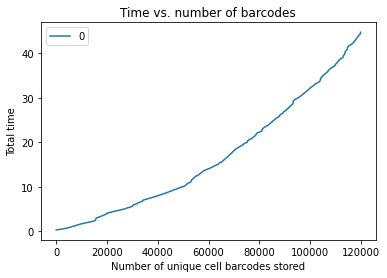

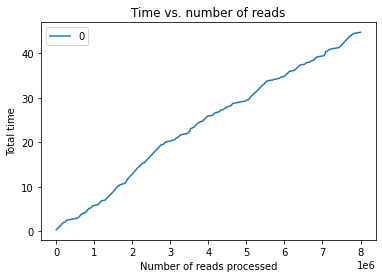

In [435]:
from matplotlib import pyplot as plt

pd.DataFrame.from_dict(num_barcodes_to_seconds, orient='index').plot()
plt.ylabel("Total time")
plt.xlabel("Number of unique cell barcodes stored")
plt.title("Time vs. number of barcodes")

pd.DataFrame.from_dict(num_reads_to_seconds, orient='index').plot()
plt.ylabel("Total time")
plt.xlabel("Number of reads processed")
plt.title("Time vs. number of reads")

In [442]:
import numpy as np

max_reads = np.max(list(num_reads_to_seconds.keys()))
max_seconds = num_reads_to_seconds.get(max_reads)
max_kb = num_reads_to_kb.get(max_reads)
seconds_per_read = max_seconds/max_reads
kb_per_read = max_kb/max_reads
print(seconds_per_read, kb_per_read)

5.594963224604726e-06 0.000655374


In [443]:
reads_per_cell = 50000
total_cells = 20000
total_reads = reads_per_cell * total_cells
print(total_reads)

1000000000


In [444]:
total_estimated_time = total_reads * seconds_per_read
print('Estimated total time in minutes for {} reads: {} minutes'.format(total_reads, round(total_estimated_time/60), 3))
total_estimated_kb = total_reads * kb_per_read
print('Estimated total kilobytes for {} reads: {} kb'.format(total_reads, total_estimated_kb))


Estimated total time in minutes for 1000000000 reads: 93 minutes
Estimated total kilobytes for 1000000000 reads: 655374.0 kb


Text(0.5, 1.0, 'Memory requirements vs. number of reads')

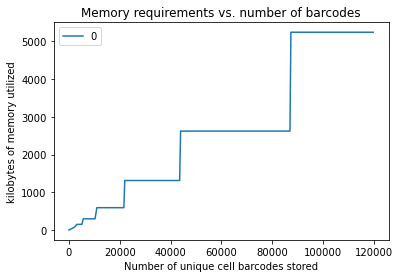

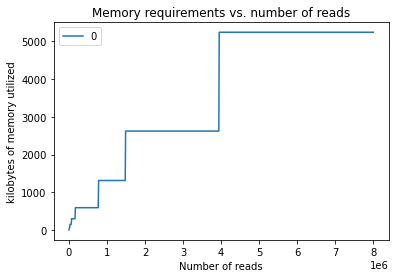

In [445]:
from matplotlib import pyplot as plt

pd.DataFrame.from_dict(num_barcodes_to_kb, orient='index').plot()
plt.ylabel("kilobytes of memory utilized")
plt.xlabel("Number of unique cell barcodes stored")
plt.title("Memory requirements vs. number of barcodes")


pd.DataFrame.from_dict(num_reads_to_kb, orient='index').plot()
plt.ylabel("kilobytes of memory utilized")
plt.xlabel("Number of reads")
plt.title("Memory requirements vs. number of reads")

In [446]:
num_reads_per_barcode_df = pd.DataFrame.from_dict(barcode_counts, orient='index', columns=['reads']).sort_values('reads')

In [447]:
num_reads_per_barcode_df.sum()

reads    521346
dtype: int64

In [448]:
skipped_for_deletions_count

23882